In [22]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import datetime
import numerapi

from sklearn import linear_model
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import scipy
import numpy
from scipy import stats

import lightgbm as lgb

import sys
sys.path.append("C:/Users/tyrab/tyler_python/numerai_public/")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# some API calls do not require logging in
napi = numerapi.NumerAPI(verbosity="info")

In [3]:
# get competitions
all_competitions = napi.get_competitions()
# get leaderboard for the current round
leaderboard = napi.get_leaderboard()
# check if a new round has started
if napi.check_new_round():
    print("new round has started wihtin the last 24hours!")
else:
    print("no new round within the last 24 hours")

2022-04-27 06:16:14,366 INFO numerapi.base_api: getting rounds...
C:\Users\tyrab\AppData\Roaming\Python\Python37\site-packages\cryptography\hazmat\backends\openssl\x509.py:17: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,


no new round within the last 24 hours


In [4]:
# download current dataset
napi.download_current_dataset(unzip=True)

2022-04-27 06:16:21,726 INFO numerapi.utils: starting download
.\numerai_dataset_313.zip: 100%|███████████████████████████████████████████████████▉| 452M/453M [00:48<00:00, 9.67MB/s]2022-04-27 06:17:10,855 INFO numerapi.base_api: unzipping file...
.\numerai_dataset_313.zip: 453MB [01:00, 9.67MB/s]                                                                     

'.\\numerai_dataset_313.zip'

In [37]:
tournament_number = napi.get_current_round()
TOURNAMENT_NAME = "nomi"
TARGET_NAME = "target"
PREDICTION_NAME = "prediction"

C:\Users\tyrab\AppData\Roaming\Python\Python37\site-packages\cryptography\hazmat\backends\openssl\x509.py:17: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,


In [6]:
training_data = pd.read_csv("./numerai_dataset_"+str(tournament_number)+"/numerai_training_data.csv")
tournament_data = pd.read_csv("./numerai_dataset_"+str(tournament_number)+"/numerai_tournament_data.csv")

In [27]:
training_data['erano'] = training_data.era.str.strip('era').astype('int')

validation_data = tournament_data[tournament_data.data_type == 'validation'].reset_index(drop=True)
validation_data['erano'] = validation_data.era.str.strip('era').astype('int')

In [32]:
train_val_combined = training_data.append(validation_data)

# Lets Take a Closer Look at the Features and correlation with the target

In [105]:
features = [f for f in train_val_combined.columns if 'feature' in f]

In [112]:
corrs_by_era = train_val_combined.groupby(['data_type', 'erano']).corr(method='spearman')

In [122]:
corrs_by_era.head()

feature_intelligence1  \
data_type erano                                                
train     1     feature_intelligence1               1.000000   
                feature_intelligence2              -0.183064   
                feature_intelligence3              -0.215442   
                feature_intelligence4               0.605645   
                feature_intelligence5              -0.030718   

                                       feature_intelligence2  \
data_type erano                                                
train     1     feature_intelligence1              -0.183064   
                feature_intelligence2               1.000000   
                feature_intelligence3               0.915525   
                feature_intelligence4              -0.265463   
                feature_intelligence5               0.202574   

                                       feature_intelligence3  \
data_type erano                                                
train     1     feature_intelligence1              -0.215442   
                feature_intelligence2               0.915525   
                feature_intelligence3               1.000000   
                feature_intelligence4              -0.275010   
                feature_intelligence5               0.181403   

                                       feature_intelligence4  \
data_type erano                                                
train     1     feature_intelligence1               0.605645   
                feature_intelligence2              -0.265463   
                feature_intelligence3              -0.275010   
                feature_intelligence4               1.000000   
                feature_intelligence5              -0.021586   

                                       feature_intelligence5  \
data_type erano                                                
train     1     feature_intelligence1              -0.030718   
                feature_intelligence2               0.202574   
                feature_intelligence3               0.181403   
                feature_intelligence4              -0.021586   
                feature_intelligence5               1.000000   

                                       feature_intelligence6  \
data_type erano                                                
train     1     feature_intelligence1               0.163346   
                feature_intelligence2              -0.103570   
                feature_intelligence3              -0.094645   
                feature_intelligence4               0.075758   
                feature_intelligence5              -0.010793   

                                       feature_intelligence7  \
data_type erano                                                
train     1     feature_intelligence1               0.212536   
                feature_intelligence2              -0.074097   
                feature_intelligence3              -0.089664   
                feature_intelligence4               0.102740   
                feature_intelligence5              -0.041719   

                                       feature_intelligence8  \
data_type erano                                                
train     1     feature_intelligence1               0.678290   
                feature_intelligence2              -0.211914   
                feature_intelligence3              -0.221876   
                feature_intelligence4               0.845787   
                feature_intelligence5              -0.021586   

                                       feature_intelligence9  \
data_type erano                                                
train     1     feature_intelligence1              -0.391481   
                feature_intelligence2               0.491987   
                feature_intelligence3               0.474907   
                feature_intelligence4              -0.396227   
                feature_intelligence5               0.107444   

In [118]:
# Do some manipulation to get in a better format
corrs_by_era1 = corrs_by_era.reset_index()
corrs_by_era1 = corrs_by_era1.set_index(['data_type', 'erano', 'level_2']) 
corrs_by_era_w_target = corrs_by_era1['target'].reset_index()
corrs_by_era_w_target = corrs_by_era_w_target.rename(columns={'level_2': 'feature', 'target': 'correlation'})
corrs_by_era_w_target = corrs_by_era_w_target[(corrs_by_era_w_target.feature.isin(features))]

In [229]:
avg_corr = corrs_by_era_w_target.groupby('feature').correlation.mean().reset_index()
avg_std = corrs_by_era_w_target.groupby('feature').correlation.std().reset_index()
avg_skew = corrs_by_era_w_target.groupby('feature').correlation.skew().reset_index()
avg_std = avg_std.rename(columns={'correlation': 'stddev'})
avg_skew = avg_skew.rename(columns={'correlation': 'skewness'})
avg_corr_std = avg_corr.merge(avg_std, left_on = 'feature', right_on = 'feature')
avg_corr_std_skew = avg_corr_std.merge(avg_skew, left_on = 'feature', right_on = 'feature') 

In [230]:
# Add a color to the feature groups 
cat_group = []
for feat in avg_corr_std_skew.feature:
    if 'intelligence' in feat:
        cat_group += ['intelligence']
    elif 'charisma' in feat:
        cat_group += ['charisma']
    elif 'strength' in feat:
        cat_group += ['strength']
    elif 'dexterity' in feat:
        cat_group += ['dexterity']
    elif 'constitution' in feat:
        cat_group += ['constitution']
    elif 'wisdom' in feat:
        cat_group += ['wisdom']
        
avg_corr_std_skew['feat_cat_group'] = cat_group

conditions = [
    (stack_frame['feat_cat_group'] == 'charisma'),
    (stack_frame['feat_cat_group'] == 'constitution'),
    (stack_frame['feat_cat_group'] == 'dexterity'),
    (stack_frame['feat_cat_group'] == 'intelligence'),
    (stack_frame['feat_cat_group'] == 'strength'),
    (stack_frame['feat_cat_group'] == 'wisdom')
    ]

# create a list of the values we want to assign for each condition
values = ['red', 'blue', 'green', 'yellow', 'orange', 'black']

# create a new column and use np.select to assign values to it using our lists as arguments
avg_corr_std_skew['color'] = np.select(conditions, values)

In [234]:
avg_corr_std_skew['sharpe'] = avg_corr_std_skew.stddev/abs(avg_corr_std_skew.correlation)
avg_corr_std_skew = avg_corr_std_skew.sort_values(by='correlation')

<BarContainer object of 310 artists>

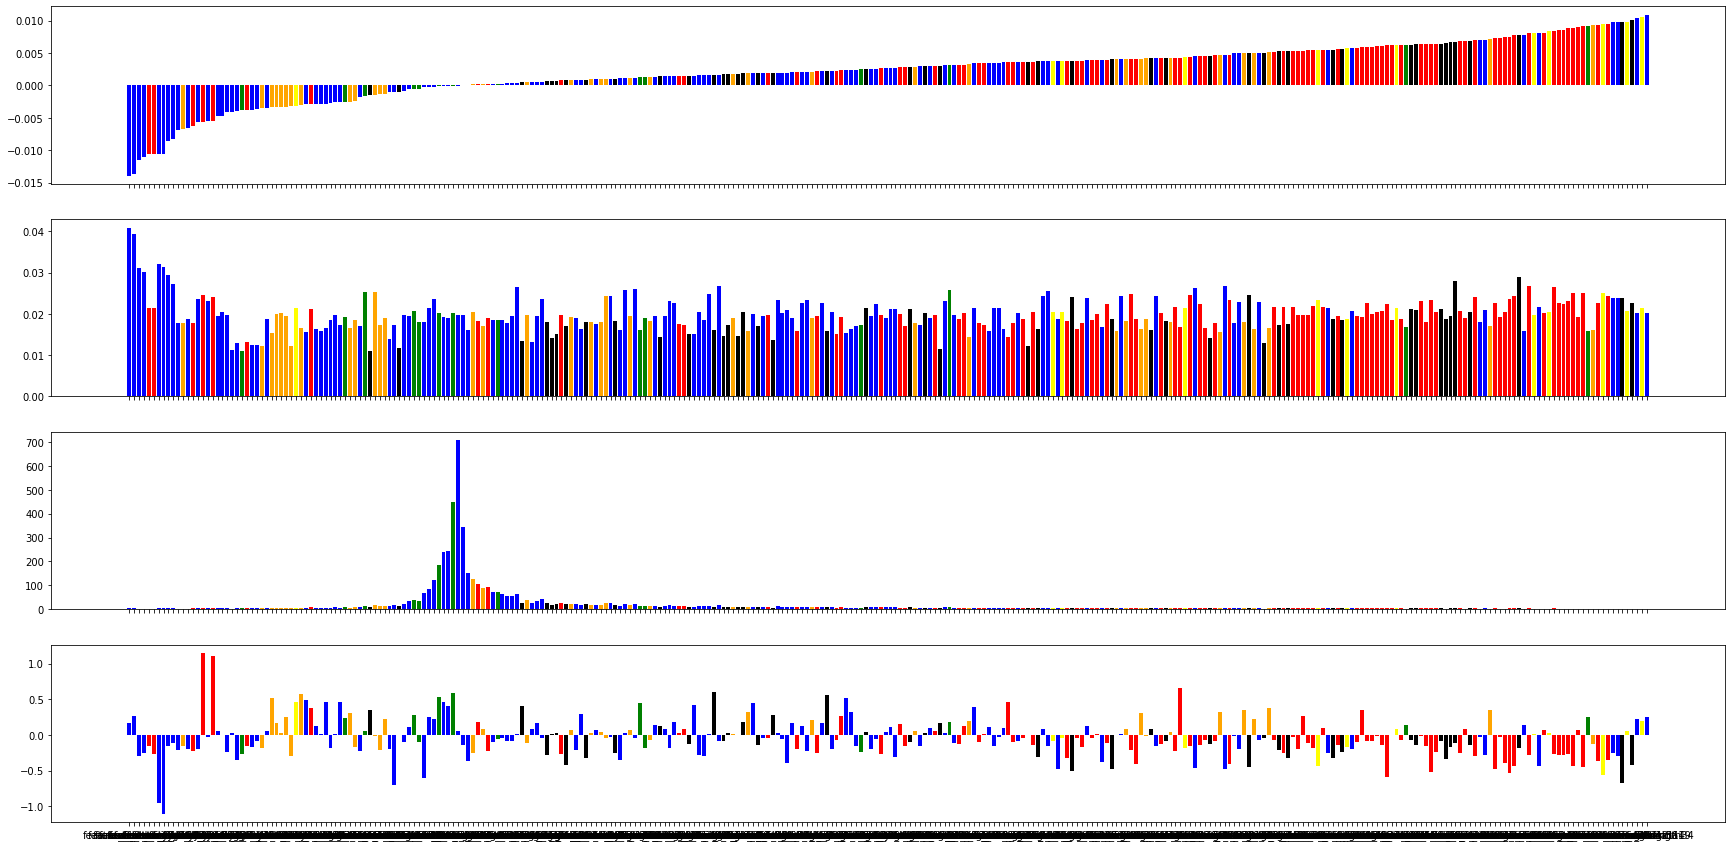

In [235]:
fig, ax = plt.subplots(4,1, figsize=(30,15), sharex=True)
ax[0].bar(avg_corr_std_skew.feature, avg_corr_std_skew.correlation, color=avg_corr_std_skew.color)
ax[1].bar(avg_corr_std_skew.feature, avg_corr_std_skew.stddev, color=avg_corr_std_skew.color)
ax[2].bar(avg_corr_std_skew.feature, avg_corr_std_skew.sharpe, color=avg_corr_std_skew.color)
ax[3].bar(avg_corr_std_skew.feature, avg_corr_std_skew.skewness, color=avg_corr_std_skew.color)

In [233]:
def get_feature_stats(df):
    
    stack_frame = pd.DataFrame()
    feat_list = df.feature.unique()
    
    for feat in feat_list:
        feature_frame = df[df.feature == feat].reset_index(drop=True)
        mean = feature_frame.groupby(['data_type', 'feature']).correlation.mean().reset_index()
        std = feature_frame.groupby(['data_type', 'feature']).correlation.std().reset_index()
        frame = [[feat, mean.correlation.values[0], std.correlation.values[0]]]
        df_pd = pd.DataFrame(frame, columns=['data_type', 'feature', 'mean_corr', 'std_corr'])
        stack_frame = stack_frame.append(df_pd)
        
    return stack_frame
    

In [215]:
stack_frame = get_feature_stats(corrs_by_era_w_target)

ValueError: 4 columns passed, passed data had 3 columns

<BarContainer object of 310 artists>

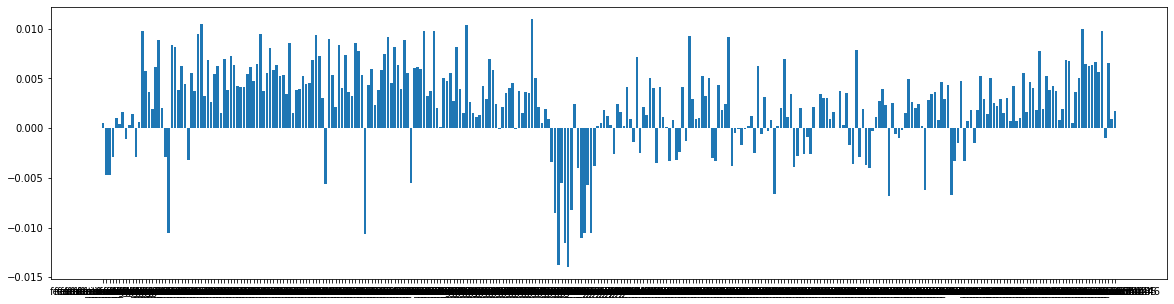

In [210]:
plt.figure(figsize=(20,5))
plt.bar(stack_frame.feature, stack_frame.mean_corr)

fig, ax = plt.subplots(2,1, figsize=(20,10), sharex=True)
ax[0].bar(avg_corr_train.feature, avg_corr_train.correlation, color=avg_corr_train.color)
ax[1].bar(avg_corr_val.feature, avg_corr_val.correlation, color=avg_corr_val.color)

In [137]:
corrs_by_era_w_target.groupby(['feature', 'data_type']).correlation.agg(average_corr = 'mean', std_corr = 'std').reset_index()

,feature,data_type,average_corr,std_corr
0,feature_charisma1,train,0.010012,0.020330
1,feature_charisma1,validation,0.009026,0.022064
2,feature_charisma10,train,0.009214,0.020723
3,feature_charisma10,validation,0.004692,0.019886
4,feature_charisma11,train,0.008886,0.019954
...,...,...,...,...
615,feature_wisdom7,validation,-0.000735,0.015805
616,feature_wisdom8,train,0.004979,0.024691
617,feature_wisdom8,validation,0.005209,0.024772
618,feature_wisdom9,train,0.003514,0.020679


In [62]:
obs_count = train_val_combined.groupby('erano').target.count()

<BarContainer object of 148 artists>

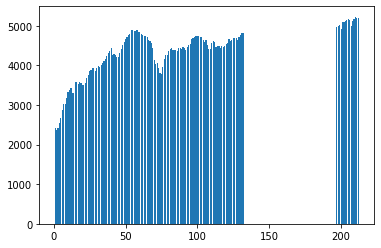

In [63]:
plt.bar(obs_count.index, obs_count.values)

In [8]:
features = [f for f in training_data.columns if 'feature' in f]
target = [f for f in training_data.columns if 'target' in f]

In [12]:
training_data.describe()

,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,...,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target,erano
count,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,...,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000
mean,0.499981,0.499979,0.499979,0.499981,0.499977,0.499977,0.499977,0.499981,0.499980,0.499980,...,0.499982,0.499974,0.499980,0.499982,0.499980,0.499974,0.499979,0.499971,0.499997,64.001987
std,0.353596,0.353593,0.353593,0.353596,0.353587,0.353587,0.353587,0.353596,0.352099,0.352099,...,0.353139,0.351328,0.350662,0.352151,0.352965,0.351328,0.347689,0.353419,0.223268,33.332945
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,...,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.500000,37.000000
50%,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,64.000000
75%,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,...,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.500000,93.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,120.000000


array([[<AxesSubplot:title={'center':'feature_intelligence10'}>]],
      dtype=object)

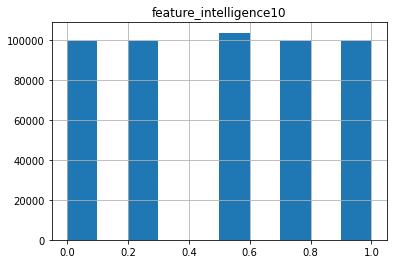

In [21]:
training_data[['feature_intelligence10']].hist()

In [52]:
clf = lgb.LGBMRegressor(n_estimators = 100,  learning_rate = 0.01, colsample_by_tree = 0.1, objective='mse', metric='None')
clf.fit(train_val_combined[features], train_val_combined[target])

# , eval_set = [(X_test, Y_test)], eval_metric=correlation_score, early_stopping_rounds = 500, verbose=0

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_by_tree=0.1,
              colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
              max_depth=-1, metric='None', min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=31, objective='mse', random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [53]:
train_val_combined[PREDICTION_NAME] = clf.predict(train_val_combined[features])

In [54]:
from dataframe_functions.scoring_functions import score, payout

# Submissions are scored by spearman correlation
def score(df):
    # method="first" breaks ties based on order in array
    pct_ranks = df[PREDICTION_NAME].rank(pct=True, method="first")
    targets = df[TARGET_NAME]
    return np.corrcoef(targets, pct_ranks)[0, 1]

correlations = train_val_combined.groupby("erano").apply(score)
print(f"On training the correlation has mean {correlations.mean()} and std {correlations.std()}")
print(f"On training the average per-era payout is {payout(correlations).mean()}")


On training the correlation has mean 0.07731947357963585 and std 0.03475368861038863
On training the average per-era payout is 0.07731947357963585


<BarContainer object of 148 artists>

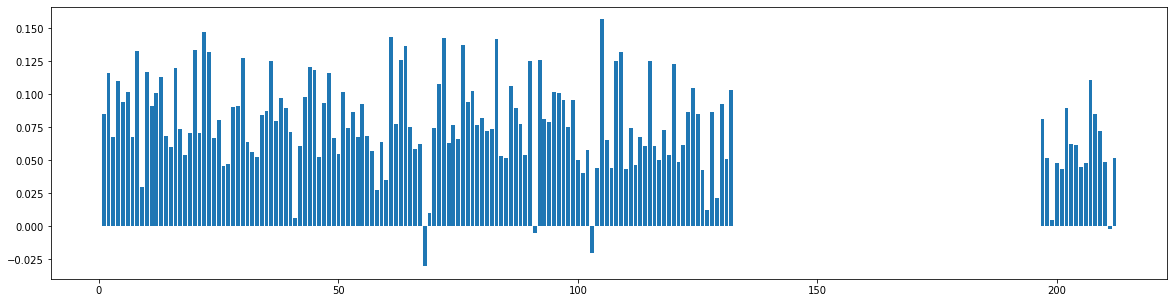

In [60]:
plt.figure(figsize=(20,5))
correlations = correlations.sort_values()
plt.bar(correlations.index, correlations.values)

In [99]:
era1 = train_val_combined[train_val_combined.erano <= 50].reset_index(drop=True)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(era1[features], era1[target], test_size=0.5, random_state=42)

In [101]:
clf = lgb.LGBMRegressor(n_estimators = 200,  learning_rate = 0.01, colsample_by_tree = 0.1, objective='mse', metric='None')
clf.fit(era1[features], era1[target])
era1[PREDICTION_NAME] = clf.predict(era1[features])
correlations = era1.groupby("erano").apply(score)
print(correlations.mean())

0.16502369513523743


In [102]:
clf = lgb.LGBMRegressor(n_estimators = 200,  learning_rate = 0.01, colsample_by_tree = 0.1, objective='mse', metric='None')
clf.fit(X_train, y_train)
era1[PREDICTION_NAME] = clf.predict(era1[features])
correlations = era1.groupby("erano").apply(score)
print(correlations.mean())

0.14681072477311852


In [103]:
clf = lgb.LGBMRegressor(n_estimators = 200,  learning_rate = 0.01, colsample_by_tree = 0.1, objective='mse', metric='None')
clf.fit(X_test, y_test)
era1[PREDICTION_NAME] = clf.predict(era1[features])
correlations = era1.groupby("erano").apply(score)
print(correlations.mean())

0.14665356828914639


In [ ]:

def hyperopt_train_test(params):
    
    clf = lgb.LGBMRegressor(**params, objective='mse', metric='None')   
    clf.fit(X_train[features], np.ravel(Y_train), eval_set = [(X_test, Y_test)], eval_metric=correlation_score, early_stopping_rounds = 500, verbose=0)
    preds = clf.predict(X_test[features])
    act = Y_test
    spear_corr = stats.spearmanr(act, preds)[0]
    
    loss = -1.0*spear_corr
    
    return loss

space = {'n_estimators': hp.choice('n_estimators', range(50,10000)),
          'max_depth': hp.choice('max_depth', range(1,10)),
          'colsample_bytree':hp.quniform('colsample_bytree', 0.005, 0.5, 0.005),
          'learning_rate': hp.quniform('learning_rate', 0.005, 0.5, 0.005),
          'subsample': hp.quniform('subsample', 0.05, 0.95, 0.01)}

def f(params):
    loss = hyperopt_train_test(params)
    return {'loss': loss, 'status': STATUS_OK}

trials = Trials()